In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [3]:
data = pd.read_csv('synthetic_drug_target_interaction.csv')




In [10]:
X = data.drop('interaction', axis=1).values
y = data['interaction'].values

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
def build_model(hp):  # hp is passed by the tuner
    model = Sequential()
    # Input Layer
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))

    # Adding Hidden Layers based on Hyperparameters
    for i in range(hp.Int('num_layers', 1, 3)):  # The number of hidden layers is tuned
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
from keras_tuner.tuners import Hyperband


In [15]:
tuner = Hyperband(
    build_model,  # Pass the build_model function here
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='drug_target_interaction'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.518750011920929

Best val_accuracy So Far: 0.581250011920929
Total elapsed time: 00h 02m 02s


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4910 - loss: 1.0401  
Test Accuracy: 0.4950


In [20]:
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)
print(history.history.keys())  # Print the available keys



Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8916 - loss: 0.2623 - val_accuracy: 0.4938 - val_loss: 1.0751
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9608 - loss: 0.1781 - val_accuracy: 0.5000 - val_loss: 1.2229
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9780 - loss: 0.1062 - val_accuracy: 0.5000 - val_loss: 1.4722
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0544 - val_accuracy: 0.5500 - val_loss: 1.6396
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0377 - val_accuracy: 0.4938 - val_loss: 2.0359
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0281 - val_accuracy: 0.5562 - val_loss: 2.1278
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - loss: 0.0221 - val_accuracy: 0.5250 - val_loss: 2.0532
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0143 - val_accuracy: 0.5312 - val_loss:

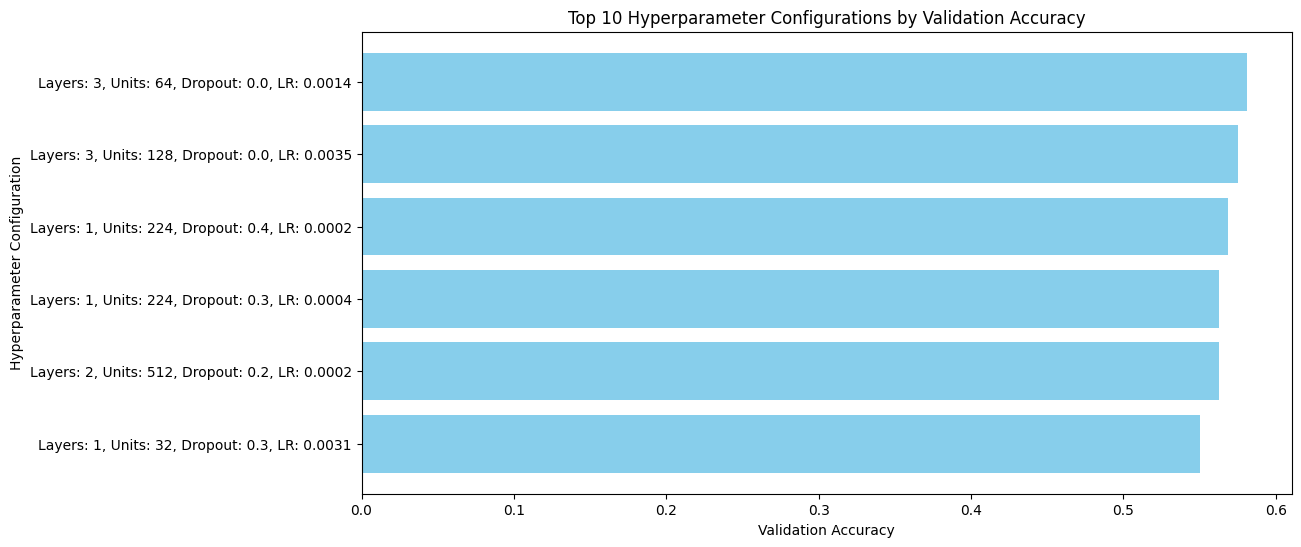

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the top trials from Hyperband
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Store results
val_accuracies = []
configurations = []

# Loop through the trials and extract the validation accuracy and hyperparameters
for trial in trials:
    val_accuracy = trial.metrics.get_last_value('val_accuracy')  # Get validation accuracy
    val_accuracies.append(val_accuracy)

    # Extract hyperparameters used for the trial
    config = trial.hyperparameters.values
    config_summary = f"Layers: {config['num_layers']}, Units: {config['units_input']}, Dropout: {config['dropout_0']:.1f}, LR: {config['lr']:.4f}"
    configurations.append(config_summary)

# Convert the results into a DataFrame
results_df = pd.DataFrame({'Configuration': configurations, 'Validation Accuracy': val_accuracies})

# Plotting the results using a bar chart
plt.figure(figsize=(12, 6))
plt.barh(results_df['Configuration'], results_df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Configuration')
plt.title('Top 10 Hyperparameter Configurations by Validation Accuracy')
plt.gca().invert_yaxis()  # Invert the Y-axis to display the best configurations at the top
plt.show()


In [22]:
# Access all the trials from Hyperband
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get the top 10 trials

# Print the hyperparameters and corresponding validation accuracy of each trial
for trial in trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Validation Accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print("------")


Trial ID: 0025
Hyperparameters: {'units_input': 64, 'num_layers': 3, 'units_0': 320, 'dropout_0': 0.0, 'lr': 0.001445187802781273, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 96, 'dropout_2': 0.0, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}
Validation Accuracy: 0.581250011920929
------
Trial ID: 0026
Hyperparameters: {'units_input': 128, 'num_layers': 3, 'units_0': 128, 'dropout_0': 0.0, 'lr': 0.003517438788693305, 'units_1': 256, 'dropout_1': 0.0, 'units_2': 384, 'dropout_2': 0.4, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Validation Accuracy: 0.574999988079071
------
Trial ID: 0001
Hyperparameters: {'units_input': 224, 'num_layers': 1, 'units_0': 128, 'dropout_0': 0.4, 'lr': 0.00015263890159365872, 'units_1': 320, 'dropout_1': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Validation Accuracy: 0.5687500238418579
------
Trial ID: 0008
Hype

In [23]:
# Retrieve the best trials from Hyperband
best_trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Print hyperparameters and validation accuracy for each trial
for trial in best_trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Validation Accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print("------")


Trial ID: 0025
Hyperparameters: {'units_input': 64, 'num_layers': 3, 'units_0': 320, 'dropout_0': 0.0, 'lr': 0.001445187802781273, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 96, 'dropout_2': 0.0, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}
Validation Accuracy: 0.581250011920929
------
Trial ID: 0026
Hyperparameters: {'units_input': 128, 'num_layers': 3, 'units_0': 128, 'dropout_0': 0.0, 'lr': 0.003517438788693305, 'units_1': 256, 'dropout_1': 0.0, 'units_2': 384, 'dropout_2': 0.4, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Validation Accuracy: 0.574999988079071
------
Trial ID: 0001
Hyperparameters: {'units_input': 224, 'num_layers': 1, 'units_0': 128, 'dropout_0': 0.4, 'lr': 0.00015263890159365872, 'units_1': 320, 'dropout_1': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Validation Accuracy: 0.5687500238418579
------
Trial ID: 0008
Hype

In [24]:
import pandas as pd

# Retrieve the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)  # Get the top 10 trials

# Store trial data in a list for easy conversion to DataFrame
trial_data = []

# Iterate over the best trials and extract data
for trial in best_trials:
    trial_info = {
        'Trial ID': trial.trial_id,
        'Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Learning Rate': trial.hyperparameters.get('lr'),
        'Num Layers': trial.hyperparameters.get('num_layers'),
        'Units Input': trial.hyperparameters.get('units_input')
    }
    trial_data.append(trial_info)

# Convert to DataFrame for better readability
df_trials = pd.DataFrame(trial_data)

# Sort the DataFrame by validation accuracy (descending)
df_trials_sorted = df_trials.sort_values(by='Validation Accuracy', ascending=False)

# Display the sorted trials
print(df_trials_sorted)

# Optionally, save to a CSV file
df_trials_sorted.to_csv('hyperband_trials.csv', index=False)


  Trial ID  Validation Accuracy  Learning Rate  Num Layers  Units Input
0     0025              0.58125       0.001445           3           64
1     0026              0.57500       0.003517           3          128
2     0001              0.56875       0.000153           1          224
3     0008              0.56250       0.000375           1          224
4     0014              0.56250       0.000202           2          512
5     0000              0.55625       0.000202           2          512
6     0016              0.55625       0.000202           2          512
7     0017              0.55625       0.000153           1          224
8     0004              0.55000       0.003149           1           32
9     0012              0.55000       0.000153           1          224


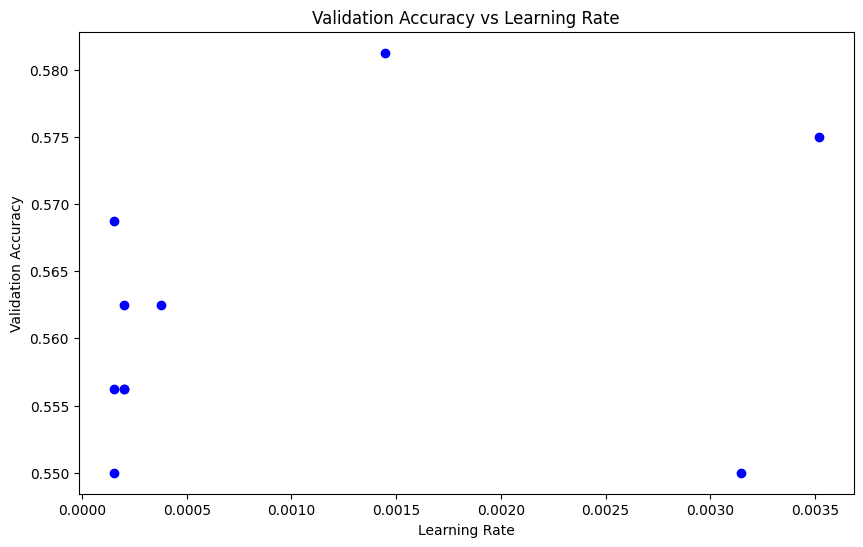

In [25]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy vs Learning Rate
plt.figure(figsize=(10, 6))

# Extract learning rates and validation accuracies
learning_rates = df_trials_sorted['Learning Rate']
val_accuracies = df_trials_sorted['Validation Accuracy']

# Create a scatter plot
plt.scatter(learning_rates, val_accuracies, color='blue')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()


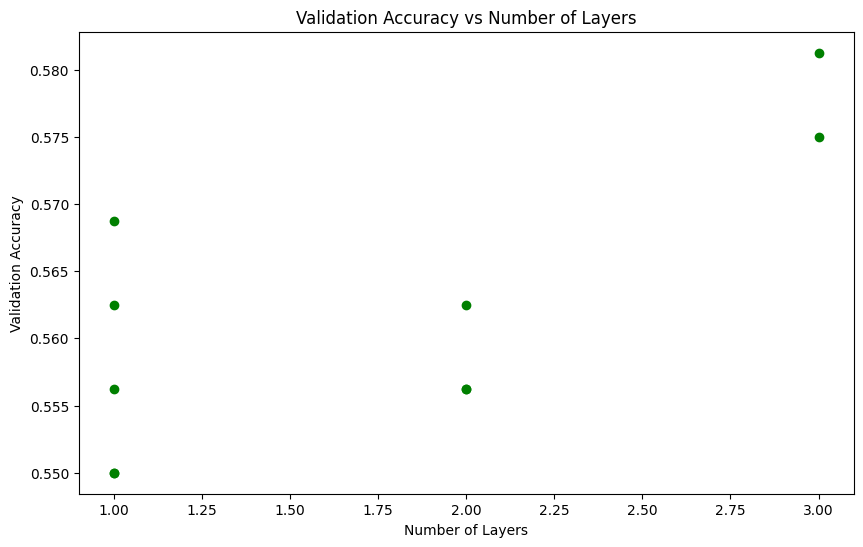

In [26]:
# Plot Validation Accuracy vs Number of Layers
plt.figure(figsize=(10, 6))

# Extract number of layers and validation accuracies
num_layers = df_trials_sorted['Num Layers']
val_accuracies = df_trials_sorted['Validation Accuracy']

# Create a scatter plot
plt.scatter(num_layers, val_accuracies, color='green')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Layers')
plt.show()


In [27]:
pip install pydot graphviz


In [28]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the Model Architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10,)))  # Example input layer with 10 features

# Add hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

print("Model architecture saved as 'model_architecture.png'")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture saved as 'model_architecture.png'


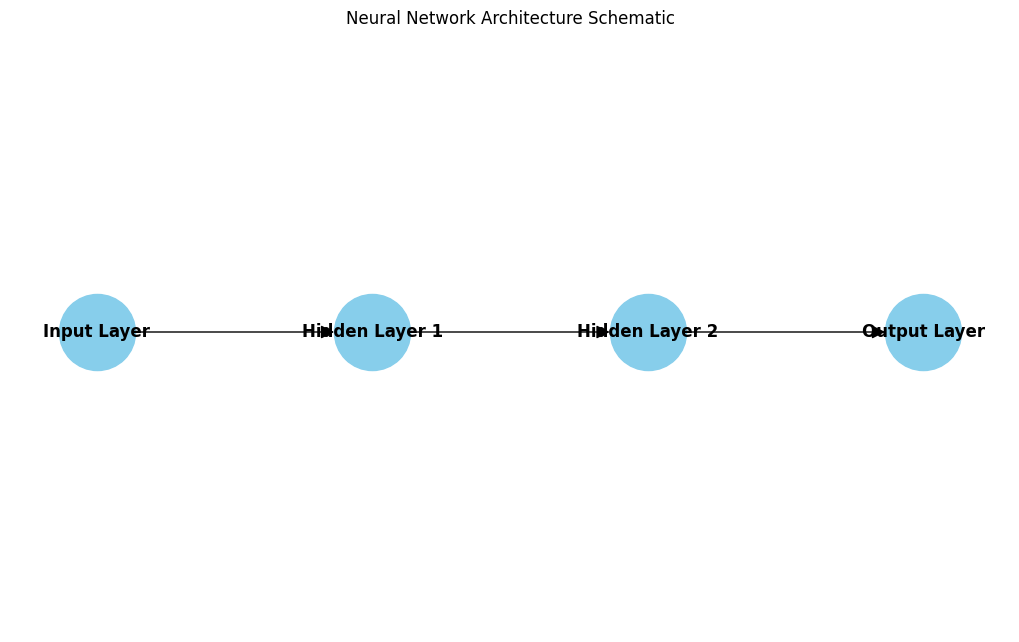

In [29]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph to represent the layers
G = nx.DiGraph()

# Add nodes (representing layers)
G.add_node("Input Layer", layer_type="input")
G.add_node("Hidden Layer 1", layer_type="hidden")
G.add_node("Hidden Layer 2", layer_type="hidden")
G.add_node("Output Layer", layer_type="output")

# Add edges (representing data flow)
G.add_edge("Input Layer", "Hidden Layer 1")
G.add_edge("Hidden Layer 1", "Hidden Layer 2")
G.add_edge("Hidden Layer 2", "Output Layer")

# Draw the network
pos = {
    "Input Layer": (0, 1),
    "Hidden Layer 1": (1, 1),
    "Hidden Layer 2": (2, 1),
    "Output Layer": (3, 1)
}
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title('Neural Network Architecture Schematic')
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
y_pred = best_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [32]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [33]:
mse = mean_squared_error(y_test, y_pred_binary)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.4850


In [34]:
from tensorflow.keras.utils import plot_model

In [35]:
mse_values = []

In [36]:
def collect_mse_trial(trial):
    # Get the trial's model and history
    model = tuner.oracle.get_trial(trial.trial_id).best_model
    # Predicting the test set
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to binary outcomes
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred_binary)
    mse_values.append(mse)

# Start the Hyperband search with the custom callback
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[collect_mse_trial])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9119 - loss: 0.2549 - val_accuracy: 0.4812 - val_loss: 1.1089
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9403 - loss: 0.1692 - val_accuracy: 0.5437 - val_loss: 1.2525
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.1064 - val_accuracy: 0.5063 - val_loss: 1.5317
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9695 - loss: 0.0769 - val_accuracy: 0.5437 - val_loss: 1.6834
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0443 - val_accuracy: 0.5188 - val_loss: 2.0446
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0205 - val_accuracy: 0.5063 - val_loss: 2.2748
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.5250 - val_loss: 2.3399
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0220 - val_accuracy: 0.5375 - val_loss

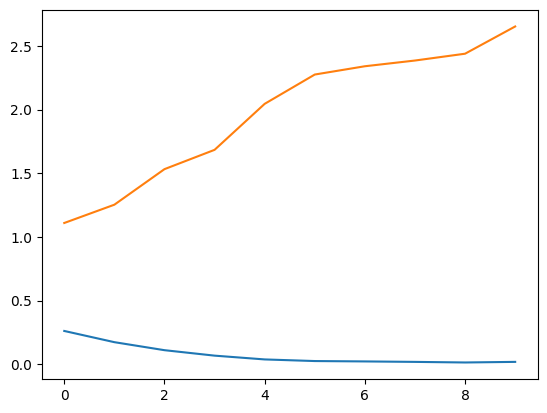

In [37]:
!pip install keras-tuner

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Store the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model to the training data to get the History object
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot using the history object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# ... (Rest of the code)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9167 - loss: 0.2828 - val_accuracy: 0.5250 - val_loss: 1.0390
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.1656 - val_accuracy: 0.5063 - val_loss: 1.2925
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9878 - loss: 0.0917 - val_accuracy: 0.5375 - val_loss: 1.5200
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9858 - loss: 0.0644 - val_accuracy: 0.5375 - val_loss: 1.6667
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0314 - val_accuracy: 0.4688 - val_loss: 2.1555
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0276 - val_accuracy: 0.4938 - val_loss: 2.2865
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0236 - val_accuracy: 0.5063 - val_loss: 2.1007
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.4812 - val_loss

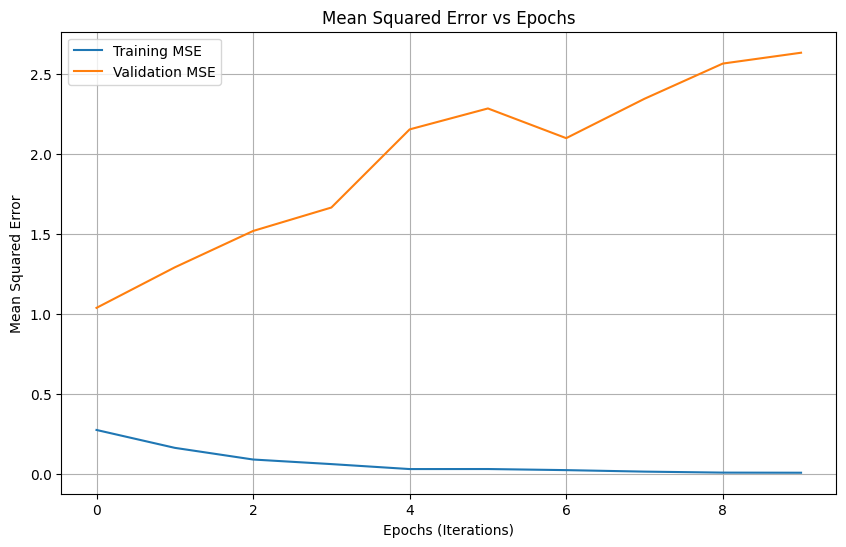

In [38]:
!pip install keras-tuner

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model and store history
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot MSE vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
!pip install keras-tuner
from sklearn.metrics import precision_score, roc_auc_score, recall_score

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities on the test set
y_pred_proba = best_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate precision, AUC-ROC, and recall
precision = precision_score(y_test, y_pred_binary)
auc_roc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred_binary)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Recall: {recall:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Precision: 0.4885
AUC-ROC: 0.5000
Recall: 0.6531
